# Extracting Facts from Texts



**Summary of current progress - jlln **
- If a sentence contains a reporting unit, a reporting term, and a number, these can be identified and extracted by exploring the graph structure of the parsed sentence.
- There are several issues yet to be addressed.
     - Poorly formatted numbers eg 1 610 are interpreted incorrectly.
     - Implicit units eg dozens stranded are ignored.
     - Cannot detect information spread across multiple sentences.
     - Does not extract locations or dates.
 

**Aside - How to use the existing codebase to get training data.**

In [33]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
pd.set_option('display.max_colwidth', -1)
import re
from collections import Counter
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from internal_displacement.pipeline import SQLArticleInterface

In [34]:
nlp = spacy.load('en')

In [35]:
pipeline = SQLArticleInterface("../sql_db.sqlite") #Connecting to pre-populated database.

In [36]:
labels,features = pipeline.get_training_data()

** Examination of text data **

Now that the training data is loaded in a useful format, I will begin looking at report extraction.
A report in this context describes:
    - A collection of entities to which something has happened.
    - It will have a reporting term (ie the thing that has happened) for example destruction of a structure.
    - It will have a reporting unit (ie the subject of the reporting term), for example a house. Note that this unit may not always be explicitly stated in the text; for example the phrase "floods left dozens stranded" implicitly refers to people.
    - It will have a quantity, for example 500 houses.
    - It should also have a date and and a location.
  

In [37]:
labels[0],features[0]

('Disasters',
 "Flash flooding across Afghanistan and Pakistan has left more than 160 dead and dozens stranded in one of South Asia's worst natural disasters this year, say officials.  The flooding, caused by unusually heavy rain, has left villagers stuck in remote areas without shelter, food or power.  Mountainous Afghanistan was the worst hit, with 61 people killed and approximately 500 traditional mud-brick homes washed away in more than a dozen villages in Sarobi, a rural district less than an hour from Kabul, officials said.  Floods left a village devastated in the remote eastern Afghan province of Nuristan. At least 60 homes were destroyed across three districts, said provincial spokesman Mohammad Yusufi. No one was killed.  Authorities have been unable to deliver aid to some badly affected villages by land as roads in the area are controlled by the Taliban, Yusufi added.  “We have asked the national government for help as have an overwhelming number of locals asking for assistan

This single story contains multiple facts:
    - more than 160 dead
    - dozens stranded
    - 61 people killed in Mountainous Afghanistan
    - 500 homes washed away in Sarobi
    - At least 60 homes were destroyed in Nuristan
    - More than fifty homes and shops destroyed in Khost and Nangarhar
    - Thousands of acres of farmland flooded in Khost and Nangarhar
    - 80 people killed in Pakistan

The challenge description describes some reporting terms and reporting units.

In [38]:
reporting_terms = [
    'displaced', 'evacuated', 'forced to flee', 'homeless', 'in relief camp',
    'sheltered', 'relocated', 'destroyed housing', 'partially destroyed housing',
    'uninhabitable housing','stranded','stuck','stranded','washed','swept','damaged','collapsed'
]

people_reporting_units = [
    'people', 'persons','lives', 'individuals', 'children', 'inhabitants', 'residents', 'migrants','dead','fatalities','casualties','deaths'
]

structure_reporting_units = [
    'families', 'households', 'houses', 'homes','dwelling','hut'
]

In [39]:
#Converting to lemmas to allow matching.
reporting_term_lemmas = [t.lemma_ for t in nlp(" ".join(reporting_terms))]
structure_unit_lemmas = [t.lemma_ for t in nlp(" ".join(structure_reporting_units))]

In [40]:
story_ = nlp(features[0])

Find sentences containing numerical tokens.

In [10]:
for sentence in story_.sents:
    if any([token.like_num for token in sentence]):
        print(sentence)

Flash flooding across Afghanistan and Pakistan has left more than 160 dead and dozens stranded in one of South Asia's worst natural disasters this year, say officials.  
Mountainous Afghanistan was the worst hit, with 61 people killed and approximately 500 traditional mud-brick homes washed away in more than a dozen villages in Sarobi, a rural district less than an hour from Kabul, officials said.  
At least 60 homes were destroyed across three districts, said provincial spokesman Mohammad Yusufi.
No one was killed.  
At least 24 people were also died in two other eastern border provinces, Khost and Nangarhar, according to local officials.
More than fifty homes and shops were destroyed and thousands of acres of farmland flooded.  
In Pakistan monsoon rains claimed more than 80 lives, local media reported.
In Karachi, the commercial capital and a southern port city that is home to 18 million people, poor neighborhoods were submerged waist-deep in water and many precincts suffered long p

In [11]:
numerical_sentences = list(filter(lambda sentence: any([token.like_num for token in sentence]), story_.sents) )

Find sentences containing both numerical tokens and reporting term lemmas.

In [12]:
for sentence in numerical_sentences:
    sentence_lemmas = [token.lemma_ for token in sentence]
    if any([sl in reporting_term_lemmas for sl in sentence_lemmas]):
        print(sentence)

Flash flooding across Afghanistan and Pakistan has left more than 160 dead and dozens stranded in one of South Asia's worst natural disasters this year, say officials.  
Mountainous Afghanistan was the worst hit, with 61 people killed and approximately 500 traditional mud-brick homes washed away in more than a dozen villages in Sarobi, a rural district less than an hour from Kabul, officials said.  
At least 60 homes were destroyed across three districts, said provincial spokesman Mohammad Yusufi.
At least 24 people were also died in two other eastern border provinces, Khost and Nangarhar, according to local officials.
More than fifty homes and shops were destroyed and thousands of acres of farmland flooded.  
In Pakistan monsoon rains claimed more than 80 lives, local media reported.
In Karachi, the commercial capital and a southern port city that is home to 18 million people, poor neighborhoods were submerged waist-deep in water and many precincts suffered long power outages.


In [13]:
def is_reporting_term_lemma_present(sentence):
    sentence_lemmas = [token.lemma_ for token in sentence]
    return any([sl in reporting_term_lemmas for sl in sentence_lemmas])

In [14]:
numerical_report_sentences = list(filter(is_reporting_term_lemma_present, numerical_sentences) )

In [15]:
numerical_report_sentences

[Flash flooding across Afghanistan and Pakistan has left more than 160 dead and dozens stranded in one of South Asia's worst natural disasters this year, say officials.  ,
 Mountainous Afghanistan was the worst hit, with 61 people killed and approximately 500 traditional mud-brick homes washed away in more than a dozen villages in Sarobi, a rural district less than an hour from Kabul, officials said.  ,
 At least 60 homes were destroyed across three districts, said provincial spokesman Mohammad Yusufi.,
 At least 24 people were also died in two other eastern border provinces, Khost and Nangarhar, according to local officials.,
 More than fifty homes and shops were destroyed and thousands of acres of farmland flooded.  ,
 In Pakistan monsoon rains claimed more than 80 lives, local media reported.,
 In Karachi, the commercial capital and a southern port city that is home to 18 million people, poor neighborhoods were submerged waist-deep in water and many precincts suffered long power out

**Find individual phrases where a reporting term relates to a quantity.**

While matching the presence of reporting terms and units is somewhat effective in identifying relevent sentences, it might be more useful to find sentences with the desired relationship between terms.

In [17]:
from nltk import Tree

In [18]:
def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_

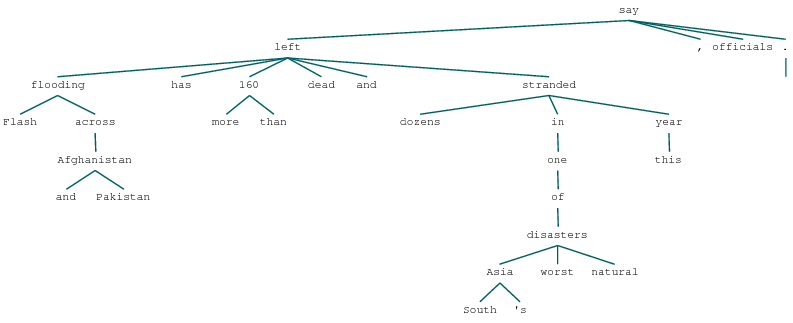

In [23]:
to_nltk_tree(numerical_report_sentences[0].root)

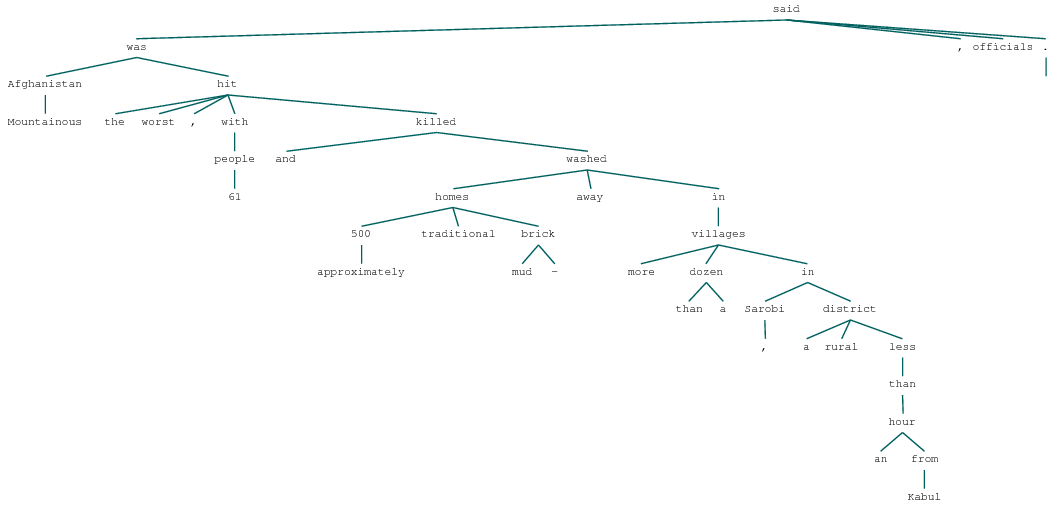

In [24]:
to_nltk_tree(numerical_report_sentences[1].root)

In [25]:
numerical_report_sentences[3]

At least 24 people were also died in two other eastern border provinces, Khost and Nangarhar, according to local officials.

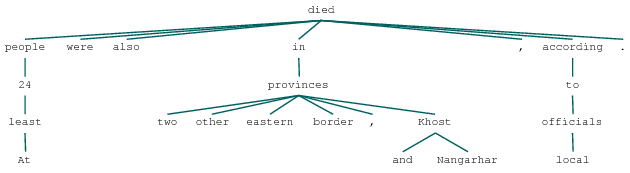

In [26]:
to_nltk_tree(numerical_report_sentences[3].root)

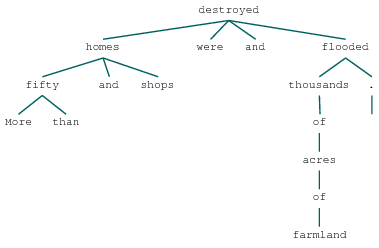

In [27]:
to_nltk_tree(numerical_report_sentences[4].root)

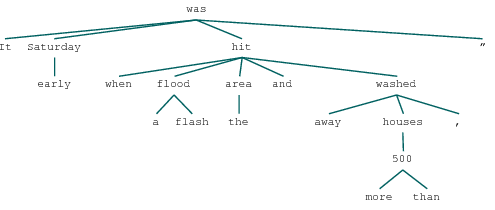

In [19]:
story2 = nlp(features[4])
numerical_sentences = list(filter(lambda sentence: any([token.like_num for token in sentence]), story2.sents) )
numerical_report_sentences = list(filter(is_reporting_term_lemma_present, numerical_sentences) )
numerical_report_sentences
to_nltk_tree(numerical_report_sentences[-2].root)

** Examining the dependency graphs, it appears that reporting term is always the parent of reporting unit, which is itself the parent of the numerical quantity. There may be an optional qualifier for the quantity as well.**

washed <- houses <- 500 <- more than

destroyed <- homes <- fifty <- more than

died <- people <- 24 <- at least

washed <- homes <- 500 <- approximately

dozens <- stranded
 


In some cases the subject (ie the reporting unit) is implicit. (eg flooding left dozens stranded obviously refers to dozens of people). (Do unspecified quantities always refer to people? I guess they could also refer to money?  Is this a a behaviour unique to English? Will we need to consider this when working with translated documents?)

**Trying to find a structural relationship between units and terms**

1) Identify a reporting term token.

2) Search the children of this token for reporting unit tokens.

3) Search the children of any reporting unit tokens for numerical terms.

4) Return a list of sequences for each reporting-term -> reporting-unit -> numerical-quantity pathway that is discovered.


This is a good point to start thinking about the data structure for extracted facts.

In [38]:
class Report:
    def __init__(self,reporting_term,reporting_unit,number,sentence):
        self.reporting_term = reporting_term,
        self.reporting_unit = reporting_unit
        self.number = number
        self.sentence = sentence
        """
        Should also store date and location.
        """
    def display(self):
        print("Reporting_Term: {}  Reporting_Unit: {}  Numerical_Term: {}".format(self.reporting_term,self.reporting_unit,self.number))
        print("    Original Sentence: {}".format(self.sentence))
        print("--------")

In [39]:
def is_reporting_term_lemma_present(sentence):
    sentence_lemmas = [token.lemma_ for token in sentence]
    return any([sl in reporting_term_lemmas for sl in sentence_lemmas])

def drill_down_from_term(term_token):
    reports = []
    children = term_token.children
    unit_children = list(filter(lambda x: x.lemma_ in structure_unit_lemmas,children))
    for uc in unit_children:
        uc_children = uc.children
        for token in uc_children:
            if token.like_num:
                numerical_term = token
                reporting_unit = uc
                reporting_term = term_token
                report = Report(reporting_term,reporting_unit,number)
                reports.append(report)
    return reports



def find_reports(story):
    reports = []
    for sentence in nlp(story).sents:
        for token in sentence:
            if token.lemma_ in reporting_term_lemmas:
                term_token = token
                children = term_token.children
                unit_children = list(filter(lambda x: x.lemma_ in structure_unit_lemmas,children))
                for uc in unit_children:
                    uc_children = uc.children
                    for token in uc_children:
                        if token.like_num:
                            number = token
                            reporting_unit = uc
                            reporting_term = term_token
                            report = Report(reporting_term,reporting_unit,number,sentence.text)
                            reports.append(report)
                            report.display()
    return reports

In [40]:
report_collection = []
for story in features[:100]:
    story_reports = find_reports(story)
    report_collection.append(story_reports)

Reporting_Term: (washed,)  Reporting_Unit: homes  Numerical_Term: 500
    Original Sentence: Mountainous Afghanistan was the worst hit, with 61 people killed and approximately 500 traditional mud-brick homes washed away in more than a dozen villages in Sarobi, a rural district less than an hour from Kabul, officials said.  
--------
Reporting_Term: (destroyed,)  Reporting_Unit: homes  Numerical_Term: 60
    Original Sentence: At least 60 homes were destroyed across three districts, said provincial spokesman Mohammad Yusufi.
--------
Reporting_Term: (destroyed,)  Reporting_Unit: homes  Numerical_Term: fifty
    Original Sentence: More than fifty homes and shops were destroyed and thousands of acres of farmland flooded.  
--------
Reporting_Term: (damaged,)  Reporting_Unit: homes  Numerical_Term: 1,500
    Original Sentence: BNA report that at least 7 people were killed and over 1,500 homes damaged.
--------
Reporting_Term: (washed,)  Reporting_Unit: houses  Numerical_Term: 500
    Origi